In [68]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import sys
import nolds as ns
import numba
from numba import njit
from numba.typed import List
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
sys.path.insert(0, "D:/GIUSEPPE/Universita/TesiMagistrale/Kuramoto/Codice/modified")
%load_ext autoreload
%autoreload 2
from kuramoto.kuramoto import *
from kuramoto.plotting import *
from kuramoto.plotting_dm import *
# the above two lines are needed in order to see the modifications in python files without restarting vscode, 2 means that all modules will be reimported
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
# Parameters
dt = 0.01 # time step
t_max = 50 # max time of the simulation
n_steps = int(t_max/dt)
A = 1
B = 2.5 # when the internal coupling is 0 there is chaotic behavior for B=5, periodic for lower values, such as B=2.5
delta = 1 # width of the frequency's lorentzian distribution 

# First network
N1 = 500 # number of nodes
coupling1 = 0.2 # coupling between oscillators (will be normalized by the number of interactions)
omega_f1 = 1.0 # frequence of the external field


# Second network
N2 = 500
coupling2 = 0.25
omega_f2 = omega_f1


# Creation of the graphs
random.seed(54545)
graph_nx1_1 = nx.barabasi_albert_graph(N1, m = 3); title1 = 'Barabasi-Albert'
graph_nx2_1 = nx.barabasi_albert_graph(N2, m = 3); title2 = 'Barabasi-Albert'

graph1_1 = nx.to_numpy_array(graph_nx1_1)
graph2_1 = nx.to_numpy_array(graph_nx2_1)


model_1 = Kuramoto_com(coupling1=coupling1, coupling2 = coupling2, dt=dt, t_max=t_max, n_nodes1=len(graph1_1),
                     n_nodes2=len(graph2_1), omega_f1 = omega_f1, omega_f2 = omega_f2, A = A, B = B)

graph_nx1_2 = nx.erdos_renyi_graph(n = N1, p = 6/(N1-1), directed = False); title2 = 'Erdos-Renyi'
graph_nx2_2 = nx.erdos_renyi_graph(n = N2, p = 6/(N2-1), directed = False); title2 = 'Erdos-Renyi'

graph1_2 = nx.to_numpy_array(graph_nx1_2)
graph2_2 = nx.to_numpy_array(graph_nx2_2)

model_2 = Kuramoto_com(coupling1=coupling1, coupling2 = coupling2, dt=dt, t_max=t_max, n_nodes1=len(graph1_2),
                       n_nodes2=len(graph2_2), omega_f1 = omega_f1, omega_f2 = omega_f2, A = A, B = B)


In [149]:
print(f'Initial parameters \n')
print(f'number of nodes: N1 = {N1}, N2 = {N2}')
print(f'coupling: c1 = {coupling1}, c2 = {coupling2}')
print(f'A = {A}')
print(f'B = {B}')
print(f'external frequency = {omega_f1}')
print(f'time step dt = {dt}')
print(f'number of temporal steps {n_steps}')
act_mat_1 = model_1.run(adj_mat1 = graph1_1, adj_mat2 = graph2_1)
ord1_1 = [Kuramoto.phase_coherence(vec) for vec in act_mat_1[:N1].T]
ord2_1 = [Kuramoto.phase_coherence(vec) for vec in act_mat_1[N1:N1+N2].T]
print(f'End of the first run')
act_mat_2 = model_2.run(adj_mat1 = graph1_2, adj_mat2 = graph2_2)
ord1_2 = [Kuramoto.phase_coherence(vec) for vec in act_mat_2[:N1].T]
ord2_2 = [Kuramoto.phase_coherence(vec) for vec in act_mat_2[N1:N1+N2].T]

Initial parameters 

number of nodes: N1 = 500, N2 = 500
coupling: c1 = 0.2, c2 = 0.25
A = 1
B = 2.5
external frequency = 1.0
time step dt = 0.01
number of temporal steps 5000
Not complete graphs
End of the first run
Not complete graphs


array([<Axes: xlabel='t', ylabel='b(t)'>,
       <Axes: title={'center': 'First network'}, xlabel='t', ylabel='r'>,
       <Axes: title={'center': 'Second network'}, xlabel='t', ylabel='r'>],
      dtype=object)

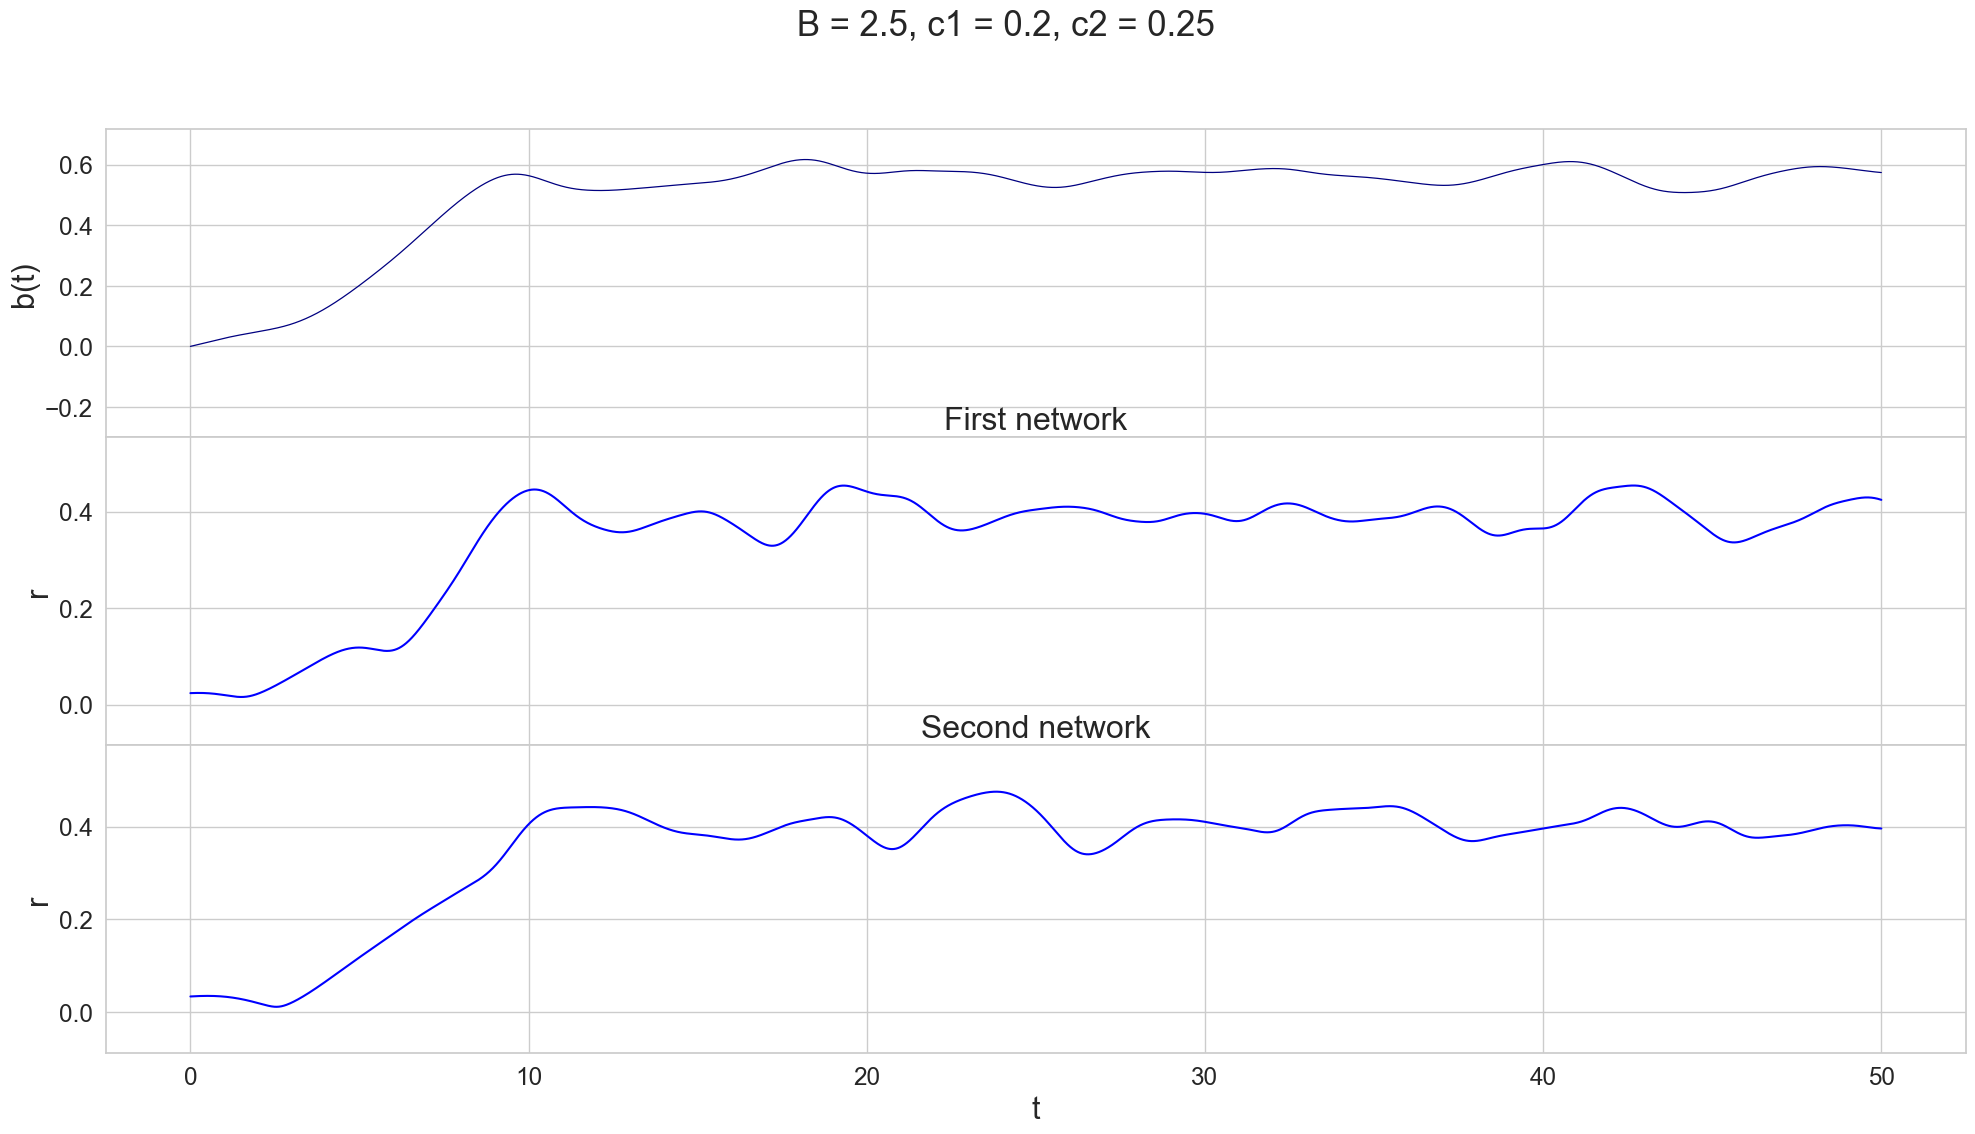

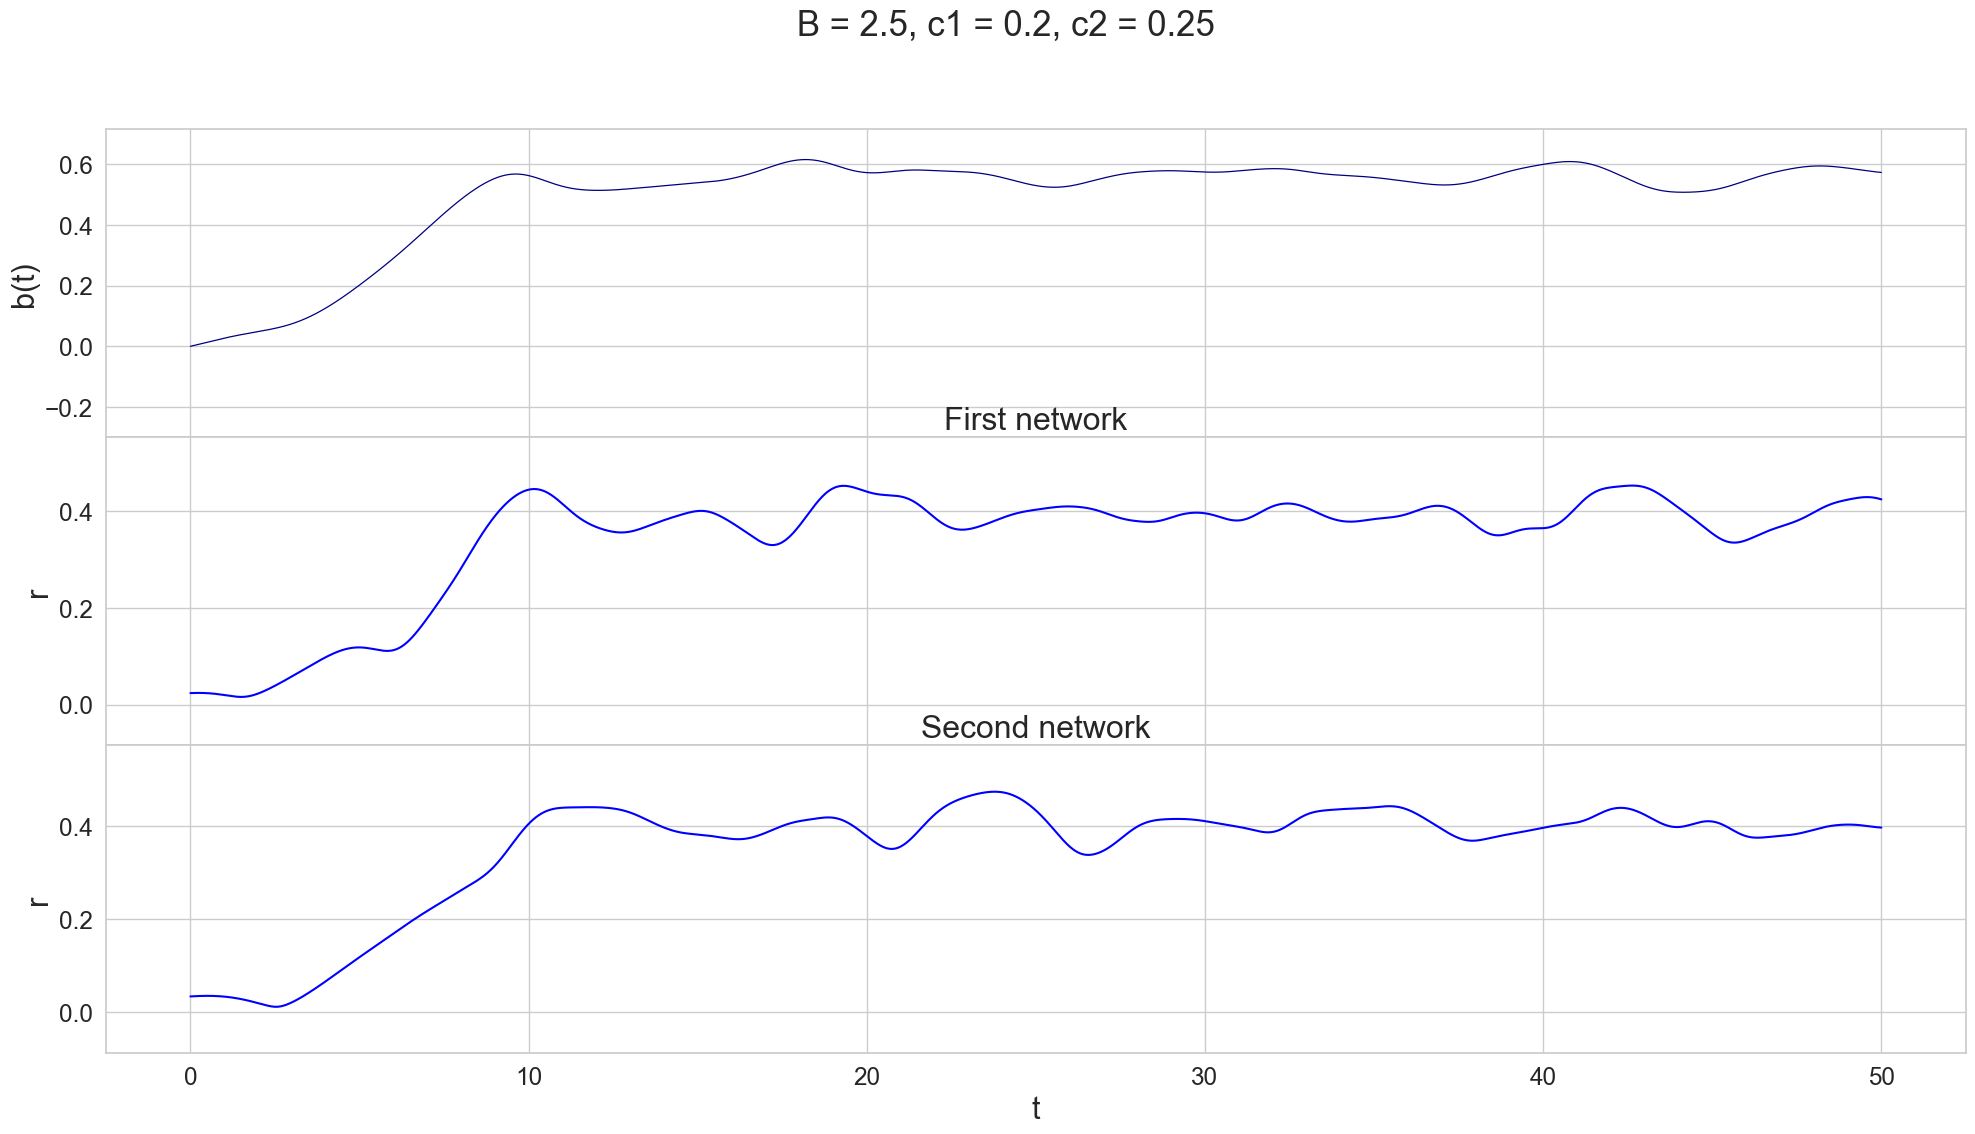

In [150]:
b_1 = act_mat_1[-1]
b_2 = act_mat_2[-1]

plot_field_order(b_1, ord1_1, ord2_1, dt, t_max, f'B = {B}, c1 = {coupling1}, c2 = {coupling2}')
plot_field_order(b_2, ord1_2, ord2_2, dt, t_max, f'B = {B}, c1 = {coupling1}, c2 = {coupling2}')

In [151]:
tau_min = 0.0003
tau_max = 100
tau_points = 50
tau_r = np.logspace(-2, 2, tau_points)
final_state_1 = act_mat_1[:,-1]
final_state_2 = act_mat_2[:,-1] 

H_1 = H_J_single1(coupling1, coupling2, final_state_1[:N1], final_state_1[N1:N1+N2], final_state_1[-1], graph1_1, graph2_1, omega_f1, A, B, t_max)
H_2 = H_J_single2(coupling1, coupling2, final_state_1[:N1], final_state_1[N1:N1+N2], final_state_1[-1], graph1_1, graph2_1, omega_f1, A, B, t_max)
H_12 = H_J(coupling1, coupling2, final_state_1[:N1], final_state_1[N1:N1+N2], final_state_1[-1], graph1_1, graph2_1, omega_f1, A, B, t_max)

rho_1 = []
S_1 = []

rho_2 = []
S_2 = []

rho_12 = []
S_12 = []

for tau in tau_r:
    print(f'tau = {round(tau, 2)}')
    rho_t_1 , S_t_1 , Z_t_1 , F_t_1, eta_t_1 = network_thermodynamics(H_1, tau)
    rho_1.append(rho_t_1)
    S_1.append(S_t_1)
    
    rho_t_2 , S_t_2 , Z_t_2 , F_t_2, eta_t_2 = network_thermodynamics(H_2, tau)
    rho_2.append(rho_t_2)
    S_2.append(S_t_2)
    
    rho_t_12 , S_t_12 , Z_t_12 , F_t_12, eta_t_12 = network_thermodynamics(H_12, tau)
    rho_12.append(rho_t_12)
    S_12.append(S_t_12)


tau = 0.01
tau = 0.01
tau = 0.01
tau = 0.02
tau = 0.02
tau = 0.03
tau = 0.03
tau = 0.04
tau = 0.04
tau = 0.05
tau = 0.07
tau = 0.08
tau = 0.1
tau = 0.12
tau = 0.14
tau = 0.17
tau = 0.2
tau = 0.24
tau = 0.29
tau = 0.36
tau = 0.43
tau = 0.52
tau = 0.63
tau = 0.75
tau = 0.91
tau = 1.1
tau = 1.33
tau = 1.6
tau = 1.93
tau = 2.33
tau = 2.81
tau = 3.39
tau = 4.09
tau = 4.94
tau = 5.96
tau = 7.2
tau = 8.69
tau = 10.48
tau = 12.65
tau = 15.26
tau = 18.42
tau = 22.23
tau = 26.83
tau = 32.37
tau = 39.07
tau = 47.15
tau = 56.9
tau = 68.66
tau = 82.86
tau = 100.0


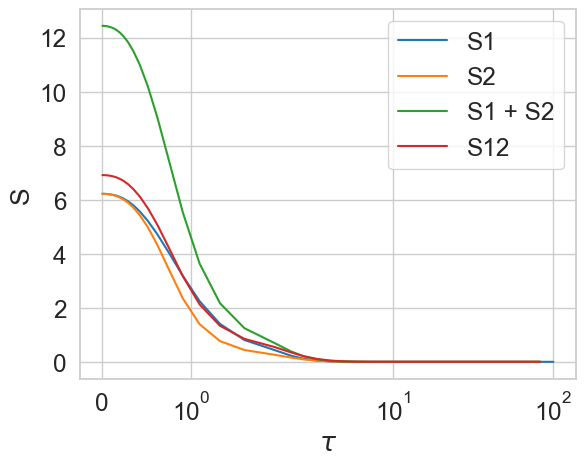

In [152]:
plt.plot(tau_r, S_1, label = 'S1')
plt.plot(tau_r, S_2, label = 'S2')
plt.plot(tau_r, np.array(S_1) + np.array(S_2), label = 'S1 + S2')
plt.plot(tau_r, S_12, label = 'S12')
plt.xlabel('$\\tau$')
plt.ylabel('S')
plt.xscale('symlog')
plt.legend()

In [ ]:
tau_min = 0.0003
tau_max = 10
tau_points = 50
tau_r = np.linspace(tau_min, tau_max, tau_points)
final_state_1 = act_mat_1[:,-1]
final_state_2 = act_mat_2[:,-1] 

H_1 = H_J(coupling1, coupling2, final_state_1[:N1], final_state_1[N1:N1+N2], final_state_1[-1], graph1_1, graph2_1, omega_f1, A, B, t_max)
H_2 = H_J(coupling1, coupling2, final_state_2[:N1], final_state_2[N1:N1+N2], final_state_2[-1], graph1_2, graph2_2, omega_f1, A, B, t_max)

rho_1 = []
S_1 = []
Z_1 = []
F_1 = []
eta_1 = []

rho_2 = []
S_2 = []
Z_2 = []
F_2 = []
eta_2 = []
for tau in tau_r:
    print(f'tau = {tau}')
    rho_t_1 , S_t_1 , Z_t_1 , F_t_1, eta_t_1 = network_thermodynamics(H_1, tau)
    rho_1.append(rho_t_1)
    S_1.append(S_t_1)
    Z_1.append(Z_t_1)
    F_1.append(F_t_1)
    eta_1.append(eta_t_1)
    
    rho_t_2 , S_t_2 , Z_t_2 , F_t_2, eta_t_2 = network_thermodynamics(H_2, tau)
    rho_2.append(rho_t_2)
    S_2.append(S_t_2)
    Z_2.append(Z_t_2)
    F_2.append(F_t_2)
    eta_2.append(eta_t_2)

In [ ]:
#plot_S(S_1, S_2, tau_r)
plt.plot(tau_r, np.real(eta_2))
plt.plot(tau_r, np.real(eta_1))